# Finite temperature
A simple example constructing a thermal MPO and then time-evolving it using ITensor

In [1]:
using ITensors
using Plots

Setup parameters

In [2]:
N = 20                     # Number of sites
cutoff = 1E-8              # Truncation allowed per step
β = 4.0                    # Inverse temperature 1/kT
δτ = 0.1                   # Imaginary time-step
T = 5.0                    # Total real time
δt = 0.1                   # Real time-step
time = 0.0:δt:T            # Time vector
s = siteinds("S=1/2", N)   # Array of site indices
c = div(N, 2);             # Centre site

Define a convenient function for constructing the vector of two-site gates for a Trotterized isotropic Heisenberg model

In [3]:
function staircase_gates(x, s, N)
    gates = ITensor[]
    for j in 1:(N - 1)
        s1 = s[j]
        s2 = s[j + 1]
        hj = op("Sz", s1) * op("Sz", s2) + 1 / 2 * op("S+", s1) * op("S-", s2) + 1 / 2 * op("S-", s1) * op("S+", s2)
        Gj = exp(x / 2 * hj)
        push!(gates, Gj)
    end
    append!(gates, reverse(gates)); # Include gates in reverse order too (N,N-1),(N-1,N-2),...
    return gates
end;

Construct gates for real-time evolution

In [4]:
re_gates = staircase_gates(-im * δt,s,N);

Construct gates for imaginary-time evolution

In [5]:
im_gates = staircase_gates(-δτ,s,N);

Construct the Hamiltonian MPO for the isotropic Heisenberg model

In [6]:
ops = OpSum()
for j in 1:(N - 1)
    ops += 1 / 2, "S+", j, "S-", j + 1
    ops += 1 / 2, "S-", j, "S+", j + 1
    ops += "Sz", j, "Sz", j + 1
end
H = MPO(ops, s);   # Make H for measuring the energy

Compute the ground state energy (zero temperature, infinite β)

In [7]:
nsweeps = 10
maxdim = [10,10,10,20,20,40,80,100,200,200]
dmrg_cutoff = [1e-8]
noise = [1E-6];

ψ0_init = randomMPS(s,linkdims=2)
energy0,ψ0 = dmrg(H,ψ0_init; nsweeps, maxdim, dmrg_cutoff, noise)
println()
println("β = inf, energy = $energy0")

After sweep 1 energy=-8.671275997603445  maxlinkdim=10 maxerr=1.22E-05 time=17.423
After sweep 2 energy=-8.682270295596286  maxlinkdim=10 maxerr=1.22E-05 time=0.075
After sweep 3 energy=-8.682274892035146  maxlinkdim=10 maxerr=1.00E-05 time=0.111
After sweep 4 energy=-8.68247287007665  maxlinkdim=20 maxerr=1.84E-08 time=0.090
After sweep 5 energy=-8.682472865593603  maxlinkdim=20 maxerr=1.93E-08 time=0.117
After sweep 6 energy=-8.682473050882411  maxlinkdim=23 maxerr=9.99E-09 time=0.108
After sweep 7 energy=-8.682473051083388  maxlinkdim=23 maxerr=9.92E-09 time=0.097
After sweep 8 energy=-8.682473051096038  maxlinkdim=23 maxerr=9.92E-09 time=0.083
After sweep 9 energy=-8.682473051097787  maxlinkdim=23 maxerr=9.92E-09 time=0.096
After sweep 10 energy=-8.682473051099635  maxlinkdim=23 maxerr=9.92E-09 time=0.101

β = inf, energy = -8.682473051099635


Compute and plot the nearest-neighbour z-z correlations along the chain

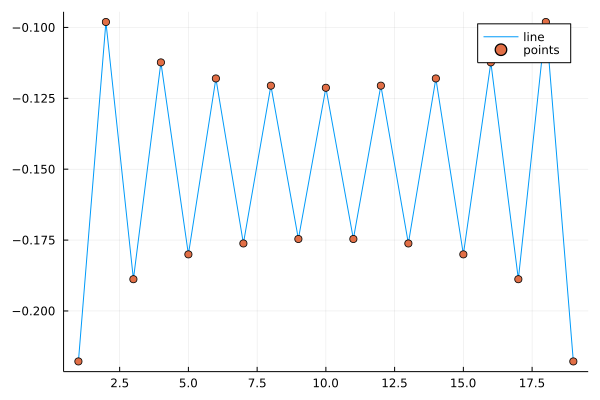

In [8]:
SzSz = zeros(N-1)
for j = 1:(N-1)
    SzSz[j] = real(inner(ψ0,apply(op("Sz", s[j]) * op("Sz", s[j+1]), ψ0; cutoff)))
end
plot(1:(N-1), SzSz, label="line")  
scatter!(1:(N-1), SzSz, label="points")

Initialize an infinite-temperature mixed state

In [9]:
ρ = MPO(s, "Id");

Perform imaginary time-evolution to the required inverse temperature

In [10]:
for k in 0:δτ:β
    energy = inner(ρ, H)
    println("β = $k, energy = $energy")
    ρ = apply(im_gates, ρ; cutoff) # Applies G ρ, one-sided but starts with ρ = 1.
    ρ = ρ / tr(ρ)
end;

β = 0.0, energy = 3.2311742677852644e-26
β = 0.1, energy = -0.7450317959626833
β = 0.2, energy = -1.5387030680582272
β = 0.3, energy = -2.351477026010195
β = 0.4, energy = -3.1510771710602676
β = 0.5, energy = -3.9079794092930196
β = 0.6, energy = -4.600008343104401
β = 0.7, energy = -5.2143653741651255
β = 0.8, energy = -5.746996876566596
β = 0.9, energy = -6.200620634738405
β = 1.0, energy = -6.582165424372565
β = 1.1, energy = -6.900570025261624
β = 1.2, energy = -7.16328440249632
β = 1.3, energy = -7.37902329421344
β = 1.4, energy = -7.558260347014433
β = 1.5, energy = -7.7068697756406
β = 1.6, energy = -7.8304839091819565
β = 1.7, energy = -7.933751372473636
β = 1.8, energy = -8.020441479920716
β = 1.9, energy = -8.093564978971818
β = 2.0, energy = -8.15525457503684
β = 2.1, energy = -8.207985670735885
β = 2.2, energy = -8.252998554739424
β = 2.3, energy = -8.291966373735104
β = 2.4, energy = -8.325850216789865
β = 2.5, energy = -8.355456294890082
β = 2.6, energy = -8.381457649666

Compute the amount of the ground state in ρ

In [11]:
println(inner(ψ0',ρ,ψ0))

0.5293167249413612


Compute and plot the z-z correlations across the chain

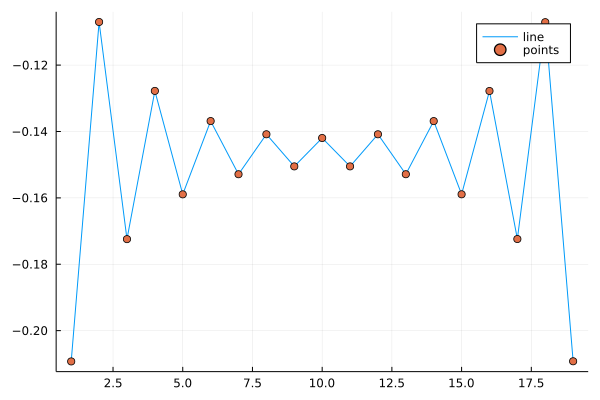

In [12]:
SzSz = zeros(N-1)
for j = 1:(N-1)
    SzSz[j] = real(tr(apply(op("Sz", s[j]) * op("Sz", s[j+1]), ρ; cutoff))) # tr(Sz Sz ρ)
end
plot(1:(N-1), SzSz, label="line")  
scatter!(1:(N-1), SzSz, label="points")

Now perturb the state with a spin-flip at the centre

In [13]:
ρ = apply(op("Sx", s[c]), ρ; cutoff); # Applies Sx ρ, left-multiplication only

MPO
[1] ((dim=2|id=439|"S=1/2,Site,n=1")', (dim=2|id=439|"S=1/2,Site,n=1"), (dim=4|id=857|"Link,n=1"))
[2] ((dim=4|id=857|"Link,n=1"), (dim=2|id=775|"S=1/2,Site,n=2")', (dim=2|id=775|"S=1/2,Site,n=2"), (dim=16|id=670|"Link,n=1"))
[3] ((dim=2|id=155|"S=1/2,Site,n=3")', (dim=2|id=155|"S=1/2,Site,n=3"), (dim=16|id=670|"Link,n=1"), (dim=57|id=964|"Link,n=1"))
[4] ((dim=2|id=105|"S=1/2,Site,n=4")', (dim=2|id=105|"S=1/2,Site,n=4"), (dim=57|id=964|"Link,n=1"), (dim=80|id=5|"Link,n=1"))
[5] ((dim=2|id=768|"S=1/2,Site,n=5")', (dim=2|id=768|"S=1/2,Site,n=5"), (dim=80|id=5|"Link,n=1"), (dim=79|id=269|"Link,n=1"))
[6] ((dim=2|id=4|"S=1/2,Site,n=6")', (dim=2|id=4|"S=1/2,Site,n=6"), (dim=79|id=269|"Link,n=1"), (dim=91|id=441|"Link,n=1"))
[7] ((dim=2|id=6|"S=1/2,Site,n=7")', (dim=2|id=6|"S=1/2,Site,n=7"), (dim=91|id=441|"Link,n=1"), (dim=87|id=168|"Link,n=1"))
[8] ((dim=2|id=197|"S=1/2,Site,n=8")', (dim=2|id=197|"S=1/2,Site,n=8"), (dim=87|id=168|"Link,n=1"), (dim=95|id=251|"Link,n=1"))
[9] ((dim=2|id

Time-evolve the perturbed state

In [14]:
SxSx = zeros(length(time))
for t in 1:length(time)
    SxSx[t] = real(tr(apply(op("Sx", s[c]), ρ; cutoff))) # tr(Sx (Sx ρ)(t))
    ρ = apply(re_gates, ρ; cutoff, apply_dag=true) # Applies G ρ G†, both left and right multiplication
end;

Plot the central x-x correlations over time

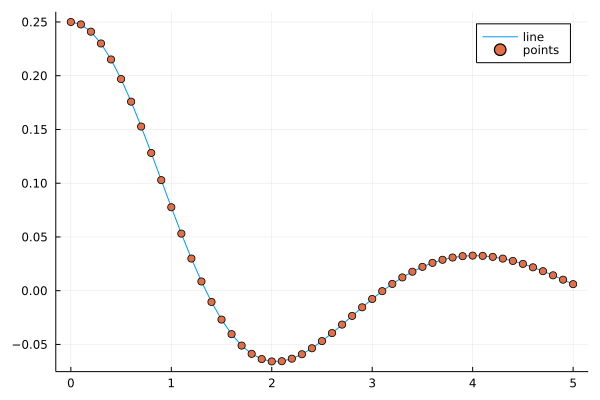

In [15]:
plot(time, SxSx, label="line")  
scatter!(time, SxSx, label="points")